<a href="https://colab.research.google.com/github/kxtubh/Startup-Scoring-Model/blob/main/Startup_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Fix the scoring calculation issues
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Startup_Scoring_Dataset.csv')

In [4]:
# Assuming df is your original dataframe
# Re-do the preprocessing correctly

# 1. Fix burn rate inversion
df['burn_rate_inverted'] = df['monthly_burn_rate_inr'].max() - df['monthly_burn_rate_inr']

In [5]:
# 2. Features to normalize (use inverted burn rate)
features_to_normalize = [
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'burn_rate_inverted',  # Use the inverted version
    'funds_raised_inr',
    'valuation_inr'
]

In [6]:
# 3. Normalize features
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])


In [7]:
# 4. Fixed scoring function
weights = {
    'team_experience': 0.20,
    'market_size_million_usd': 0.15,
    'monthly_active_users': 0.25,
    'burn_rate_inverted': 0.15,  # Use inverted burn rate
    'funds_raised_inr': 0.15,
    'valuation_inr': 0.10
}

In [8]:
def calculate_startup_score_fixed(row, weights):
    """Fixed scoring function using normalized values correctly"""
    score = 0
    score += row['team_experience'] * weights['team_experience']
    score += row['market_size_million_usd'] * weights['market_size_million_usd']
    score += row['monthly_active_users'] * weights['monthly_active_users']
    score += row['burn_rate_inverted'] * weights['burn_rate_inverted']  # Already inverted and normalized
    score += row['funds_raised_inr'] * weights['funds_raised_inr']
    score += row['valuation_inr'] * weights['valuation_inr']
    return score * 100  # Scale to 0-100

# Apply fixed scoring
df_normalized['health_score'] = df_normalized.apply(
    lambda row: calculate_startup_score_fixed(row, weights), axis=1
)

# Sort by score
df_ranked = df_normalized.sort_values('health_score', ascending=False).reset_index(drop=True)

print("FIXED SCORING RESULTS:")
print(f"Health scores now range from {df_ranked['health_score'].min():.2f} to {df_ranked['health_score'].max():.2f}")

FIXED SCORING RESULTS:
Health scores now range from 23.51 to 85.75


In [9]:
# Show top and bottom performers with fixed scores
print("\nTOP 10 STARTUPS (Fixed Scores):")
top_10 = df_ranked.head(10)[['startup_id', 'health_score']]
print(top_10.to_string(index=False))

print("\nBOTTOM 10 STARTUPS (Fixed Scores):")
bottom_10 = df_ranked.tail(10)[['startup_id', 'health_score']]
print(bottom_10.to_string(index=False))


TOP 10 STARTUPS (Fixed Scores):
startup_id  health_score
      S006     85.745622
      S077     80.242864
      S013     76.223454
      S043     75.389251
      S045     74.106638
      S033     72.915975
      S082     72.535040
      S097     71.119221
      S029     70.893121
      S050     70.256773

BOTTOM 10 STARTUPS (Fixed Scores):
startup_id  health_score
      S023     33.684115
      S095     32.422926
      S084     32.380937
      S098     31.525069
      S061     31.164291
      S052     30.142617
      S026     29.598080
      S079     29.387373
      S058     29.114293
      S055     23.507456


In [10]:
# Re-run clustering with fixed data
kmeans = KMeans(n_clusters=4, random_state=42)
df_ranked['cluster'] = kmeans.fit_predict(df_normalized[features_to_normalize])

# Calculate silhouette score
silhouette_avg = silhouette_score(df_normalized[features_to_normalize], df_ranked['cluster'])
sample_silhouette_values = silhouette_samples(df_normalized[features_to_normalize], df_ranked['cluster'])
df_ranked['silhouette_score'] = sample_silhouette_values

print(f"\nSILHOUETTE ANALYSIS (Fixed Data):")
print(f"Average Silhouette Score: {silhouette_avg:.3f}")

# Interpretation
if silhouette_avg > 0.7:
    interpretation = "Excellent - Strong, well-separated clusters"
elif silhouette_avg > 0.5:
    interpretation = "Good - Reasonable cluster structure"
elif silhouette_avg > 0.25:
    interpretation = "Weak - Overlapping clusters"
else:
    interpretation = "Poor - No meaningful cluster structure"

print(f"Cluster Quality: {interpretation}")


SILHOUETTE ANALYSIS (Fixed Data):
Average Silhouette Score: 0.148
Cluster Quality: Poor - No meaningful cluster structure


In [11]:
# Per-cluster analysis
print("\nPer-Cluster Analysis:")
for i in range(4):
    cluster_data = df_ranked[df_ranked['cluster'] == i]
    cluster_silhouette = sample_silhouette_values[df_ranked['cluster'] == i]

    print(f"Cluster {i}:")
    print(f"  Size: {len(cluster_data)} startups")
    print(f"  Avg Silhouette: {cluster_silhouette.mean():.3f}")
    print(f"  Avg Health Score: {cluster_data['health_score'].mean():.2f}")
    print(f"  Score Range: {cluster_data['health_score'].min():.2f} - {cluster_data['health_score'].max():.2f}")


Per-Cluster Analysis:
Cluster 0:
  Size: 30 startups
  Avg Silhouette: 0.188
  Avg Health Score: 52.81
  Score Range: 29.39 - 85.75
Cluster 1:
  Size: 22 startups
  Avg Silhouette: 0.124
  Avg Health Score: 48.12
  Score Range: 29.11 - 71.12
Cluster 2:
  Size: 31 startups
  Avg Silhouette: 0.149
  Avg Health Score: 50.82
  Score Range: 32.42 - 72.54
Cluster 3:
  Size: 17 startups
  Avg Silhouette: 0.107
  Avg Health Score: 49.75
  Score Range: 23.51 - 75.39


In [12]:
# Best and worst clustered startups with fixed scores
print(f"\nBest clustered startups (Fixed):")
best_clustered = df_ranked.nlargest(5, 'silhouette_score')[['startup_id', 'cluster', 'silhouette_score', 'health_score']]
print(best_clustered.to_string(index=False))

print(f"\nWorst clustered startups (Fixed):")
worst_clustered = df_ranked.nsmallest(5, 'silhouette_score')[['startup_id', 'cluster', 'silhouette_score', 'health_score']]
print(worst_clustered.to_string(index=False))


Best clustered startups (Fixed):
startup_id  cluster  silhouette_score  health_score
      S024        0          0.349061     59.651656
      S078        1          0.344344     46.227524
      S044        0          0.335647     53.896403
      S038        0          0.303430     38.951235
      S061        0          0.290464     31.164291

Worst clustered startups (Fixed):
startup_id  cluster  silhouette_score  health_score
      S018        3         -0.084059     57.923328
      S026        3         -0.047347     29.598080
      S080        1         -0.045337     45.149764
      S068        1         -0.038437     60.285233
      S009        2         -0.010161     48.964610


In [13]:
# Find optimal number of clusters
silhouette_scores = []
k_range = range(2, 8)

print(f"\nOptimal Cluster Analysis:")
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans_temp.fit_predict(df_normalized[features_to_normalize])
    score = silhouette_score(df_normalized[features_to_normalize], cluster_labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.3f}")

best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"\nOptimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")


Optimal Cluster Analysis:
k=2: Silhouette Score = 0.157
k=3: Silhouette Score = 0.174
k=4: Silhouette Score = 0.148
k=5: Silhouette Score = 0.157
k=6: Silhouette Score = 0.109
k=7: Silhouette Score = 0.142

Optimal number of clusters: 3 with silhouette score: 0.174


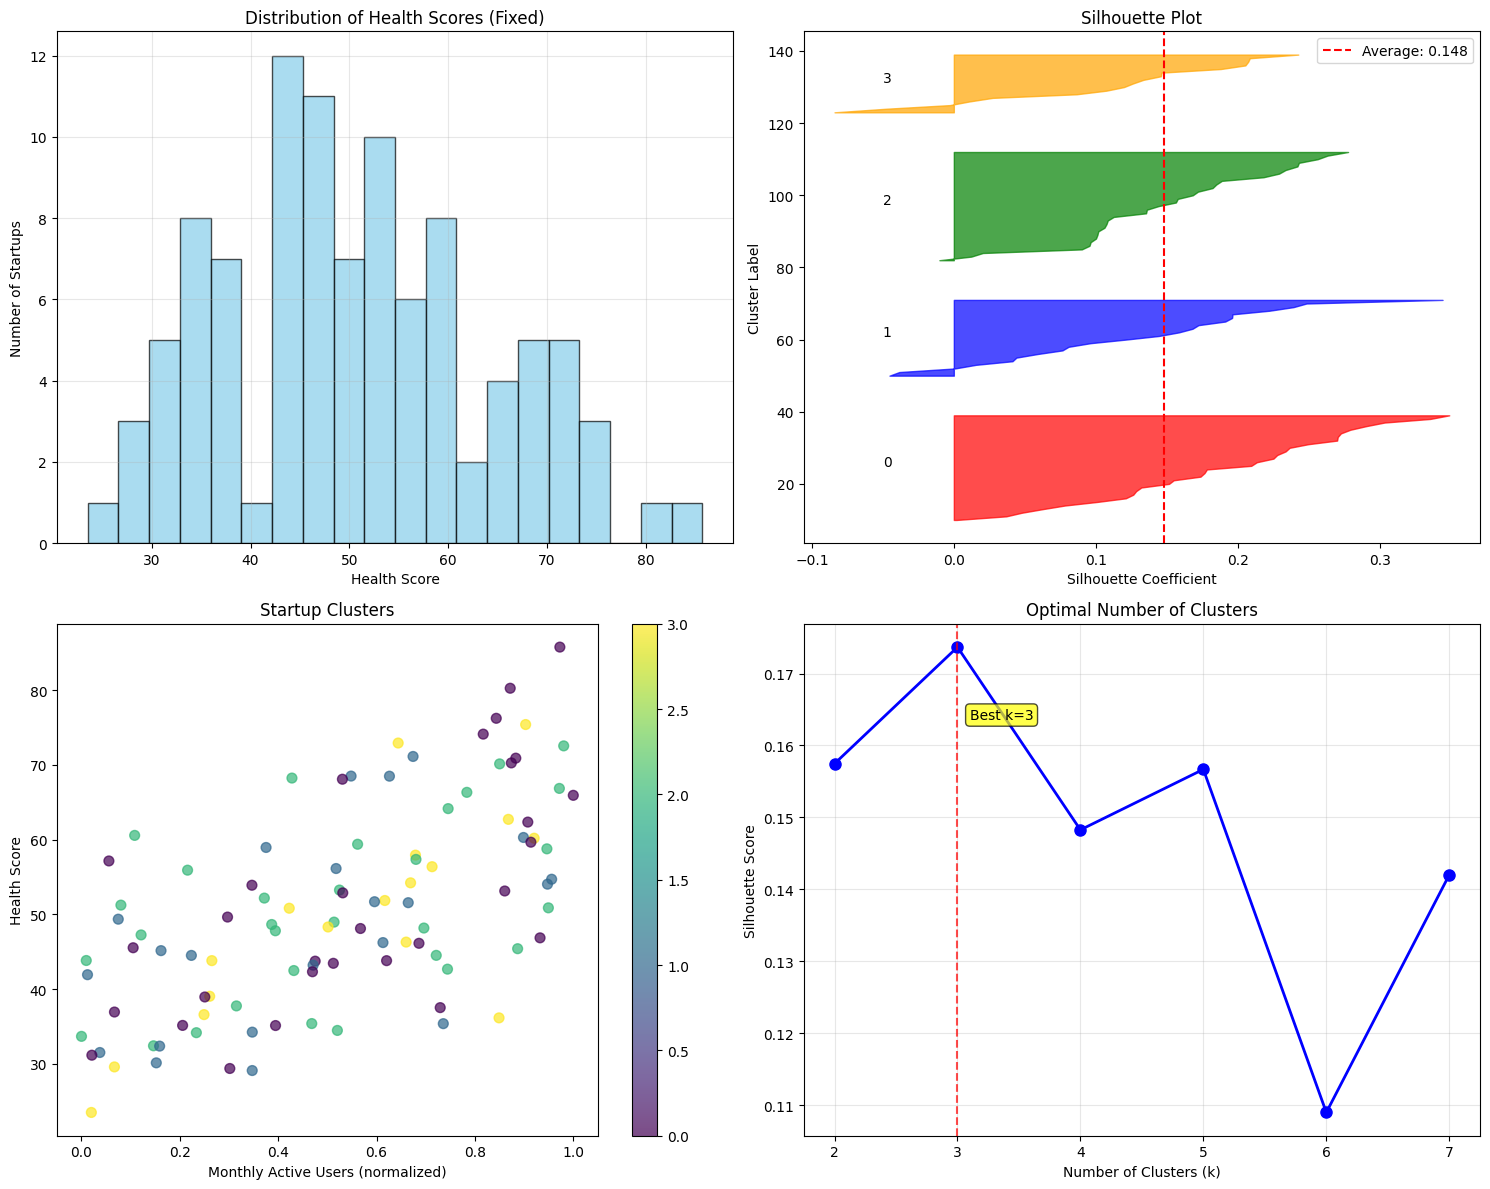

In [15]:
# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Health score distribution
ax1.hist(df_ranked['health_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Health Scores (Fixed)')
ax1.set_xlabel('Health Score')
ax1.set_ylabel('Number of Startups')
ax1.grid(True, alpha=0.3)

# 2. Silhouette plot
y_lower = 10
colors = ['red', 'blue', 'green', 'orange']

for i in range(4):
    cluster_silhouette_values = sample_silhouette_values[df_ranked['cluster'] == i]
    cluster_silhouette_values.sort()

    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[i]
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax2.axvline(x=silhouette_avg, color="red", linestyle="--",
            label=f'Average: {silhouette_avg:.3f}')
ax2.set_xlabel('Silhouette Coefficient')
ax2.set_ylabel('Cluster Label')
ax2.set_title('Silhouette Plot')
ax2.legend()

# 3. Cluster scatter plot
scatter = ax3.scatter(df_ranked['monthly_active_users'],
                     df_ranked['health_score'],
                     c=df_ranked['cluster'],
                     cmap='viridis',
                     alpha=0.7,
                     s=50)
ax3.set_xlabel('Monthly Active Users (normalized)')
ax3.set_ylabel('Health Score')
ax3.set_title('Startup Clusters')
plt.colorbar(scatter, ax=ax3)

# 4. Optimal k plot
ax4.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax4.axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
ax4.set_xlabel('Number of Clusters (k)')
ax4.set_ylabel('Silhouette Score')
ax4.set_title('Optimal Number of Clusters')
ax4.grid(True, alpha=0.3)
ax4.text(best_k + 0.1, best_score - 0.01, f'Best k={best_k}',
         bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()



In [17]:
# First, let's check what columns are actually available
print(f"\nAvailable columns in dataset:")
print(df.columns.tolist())


Available columns in dataset:
['startup_id', 'team_experience', 'market_size_million_usd', 'monthly_active_users', 'monthly_burn_rate_inr', 'funds_raised_inr', 'valuation_inr', 'burn_rate_inverted']


In [18]:
# Cluster characteristics analysis
print(f"\nCLUSTER CHARACTERISTICS:")
for i in range(4):
    cluster_data = df_ranked[df_ranked['cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} startups):")
    print(f"  Avg Health Score: {cluster_data['health_score'].mean():.2f}")

    # Show average values for key features that actually exist
    # First try to identify the correct column names
    possible_features = {
        'team_experience': ['team_experience', 'team_exp', 'experience'],
        'market_size_million_usd': ['market_size_million_usd', 'market_size', 'market_size_usd'],
        'monthly_active_users': ['monthly_active_users', 'mau', 'users', 'active_users'],
        'monthly_burn_rate_inr': ['monthly_burn_rate_inr', 'burn_rate', 'monthly_burn'],
        'funds_raised_inr': ['funds_raised_inr', 'funding', 'funds_raised'],
        'valuation_inr': ['valuation_inr', 'valuation']
    }

    # Find actual column names
    actual_features = {}
    for feature_type, possible_names in possible_features.items():
        for name in possible_names:
            if name in df.columns:
                actual_features[feature_type] = name
                break

    # Show feature averages for existing columns
    for feature_type, actual_name in actual_features.items():
        try:
            # Get original values by merging with the original dataframe
            merged_data = cluster_data.merge(df[['startup_id', actual_name]], on='startup_id', how='left')
            avg_val = merged_data[actual_name].mean()

            if 'burn_rate' in actual_name:
                print(f"  Avg {actual_name}: ₹{avg_val:,.0f}")
            elif 'valuation' in actual_name or 'funds' in actual_name:
                print(f"  Avg {actual_name}: ₹{avg_val:,.0f}")
            elif 'market_size' in actual_name:
                print(f"  Avg {actual_name}: ${avg_val:.1f}M")
            elif 'users' in actual_name:
                print(f"  Avg {actual_name}: {avg_val:,.0f}")
            else:
                print(f"  Avg {actual_name}: {avg_val:.2f}")
        except Exception as e:
            print(f"  Could not calculate avg for {actual_name}: {str(e)}")


CLUSTER CHARACTERISTICS:

Cluster 0 (30 startups):
  Avg Health Score: 52.81
  Could not calculate avg for team_experience: 'team_experience'
  Could not calculate avg for market_size_million_usd: 'market_size_million_usd'
  Could not calculate avg for monthly_active_users: 'monthly_active_users'
  Could not calculate avg for monthly_burn_rate_inr: 'monthly_burn_rate_inr'
  Could not calculate avg for funds_raised_inr: 'funds_raised_inr'
  Could not calculate avg for valuation_inr: 'valuation_inr'

Cluster 1 (22 startups):
  Avg Health Score: 48.12
  Could not calculate avg for team_experience: 'team_experience'
  Could not calculate avg for market_size_million_usd: 'market_size_million_usd'
  Could not calculate avg for monthly_active_users: 'monthly_active_users'
  Could not calculate avg for monthly_burn_rate_inr: 'monthly_burn_rate_inr'
  Could not calculate avg for funds_raised_inr: 'funds_raised_inr'
  Could not calculate avg for valuation_inr: 'valuation_inr'

Cluster 2 (31 sta

In [19]:
# Show some sample data to understand the structure better
print(f"\nSample of original data:")
print(df.head(3).to_string())

print(f"\nSample of processed data:")

print(df_ranked[['startup_id', 'health_score', 'cluster', 'silhouette_score']].head(3).to_string())


Sample of original data:
  startup_id  team_experience  market_size_million_usd  monthly_active_users  monthly_burn_rate_inr  funds_raised_inr  valuation_inr  burn_rate_inverted
0       S001                7                      789                 66299                6091495           4183839      263247468             3839898
1       S002                4                      939                 34866                9106842            666326      172927107              824551
2       S003                8                       42                 73630                8817088            649150      313090455             1114305

Sample of processed data:
  startup_id  health_score  cluster  silhouette_score
0       S006     85.745622        0          0.236572
1       S077     80.242864        0          0.047907
2       S013     76.223454        0          0.154929
